# Q function calculation in QuTiP
Gengyan Zhang, Dec 04 2015

To run the notebook, place the file [myqfunc.py](./myqfunc.py) in the same folder.

In [1]:
%matplotlib inline
import IPython
IPython.display.set_matplotlib_formats('png', 'pdf')
from scipy.misc import factorial
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

## QuTiP method
The Husimi Q function for a state $\rho$ is defined as $Q(\alpha) = \dfrac{1}{\pi}\langle\alpha|\rho|\alpha\rangle$.

In QuTip, the source code that calculates the Q function for a pure state $\psi=(\psi_0,\cdots,\psi_n)$ is

```python
def _qfunc_pure(psi, alpha_mat):

"""
Calculate the Q-function for a pure state.
"""
n = np.prod(psi.shape)
if isinstance(psi, Qobj):
    psi = psi.full().flatten()
else:
    psi = psi.T

qmat = abs(polyval(fliplr([psi / sqrt(factorial(arange(n)))])[0],
                   conjugate(alpha_mat))) ** 2

return real(qmat) * exp(-abs(alpha_mat) ** 2) / pi
```
For each $\alpha$, it calculates $\displaystyle Q(\alpha)=\left|\sum_{m=0}^n \frac{(\alpha^*)^m}{\sqrt{m!}}\psi_m\right|^2\frac{\exp(-|\alpha|^2)}{\pi}$ directly.

The problem is it uses scipy.misc.factorial to calculate $m!$, and it gives infinity when $m > 170$.

In [2]:
[factorial(170), factorial(171)]

[array(7.257415615308e+306), array(inf)]

So for a coherent state $|\alpha\rangle$ with $|\alpha|^2> 170$, The Q function becomes inaccurate.

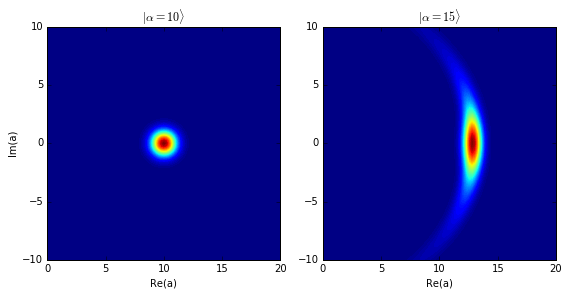

In [3]:
N = 300 # Dimension of Hilbert space
psi1 = qt.coherent(N, 10) # Coherent state |alpha=10>
psi2 = qt.coherent(N, 15) # Coherent state |alpha=15>
areal = np.linspace(0, 20, 101) # Grid for real part of alpha
aimag = np.linspace(-10, 10, 101) # Grid for imaginary part of alpha
Q1 = qt.qfunc(psi1, areal, aimag, 2) # Q function for psi1
Q2 = qt.qfunc(psi2, areal, aimag, 2) # Q function for psi2

# Plot results
plt.figure(figsize=(8, 4))
ax1 = plt.subplot(121)
plt.contourf(areal, aimag, Q1, 100)
ax1.set_aspect('equal')
plt.xlabel('Re(a)')
plt.ylabel('Im(a)')
plt.title(r'$|\alpha=10\rangle$')

ax2 = plt.subplot(122)
plt.contourf(areal, aimag, Q2, 100)
ax2.set_aspect('equal')
plt.xlabel('Re(a)')
plt.title(r'$|\alpha=15\rangle$')
plt.tight_layout()

## Modified method
To fix this, we use Stirling's approximation $n!\approx\sqrt{2\pi n}\left(\dfrac{n}{e}\right)^n$, so

$\displaystyle Q(\alpha) = \frac{1}{\pi}\left|\sum_{m=0}^{n_0}\exp\left(-\frac{|\alpha|^2}{2}\right)\frac{(\alpha^*)^m}{\sqrt{m!}}\psi_m+\sum_{m=n_0+1}^n \exp\left(-\frac{|\alpha|^2-m}{2}\right)(2\pi m)^{-1/4}\left(\frac{\alpha^*}{m}\right)^m\psi_m\right|^2$

In the code $n_0$ is set to 170.

In [4]:
from scipy import (zeros, arange, exp, real, pi,
                   sqrt, meshgrid, size, polyval, fliplr, conjugate)
import scipy.linalg as la

from qutip.qobj import Qobj, isket, isoper

# -----------------------------------------------------------------------------
# Q FUNCTION
#
def myqfunc(state, xvec, yvec, g=sqrt(2)):
    """Q-function of a given state vector or density matrix
    at points `xvec + i * yvec`.

    Parameters
    ----------
    state : qobj
        A state vector or density matrix.

    xvec : array_like
        x-coordinates at which to calculate the Wigner function.

    yvec : array_like
        y-coordinates at which to calculate the Wigner function.

    g : float
        Scaling factor for `a = 0.5 * g * (x + iy)`, default `g = sqrt(2)`.

    Returns
    --------
    Q : array
        Values representing the Q-function calculated over the specified range
        [xvec,yvec].

    """
    X, Y = meshgrid(xvec, yvec)
    avec = np.reshape(0.5 * g * (X + Y * 1j),[len(xvec)*len(yvec),1])

    if not (isoper(state) or isket(state)):
        raise TypeError('Invalid state operand to qfunc.')

    qvec = zeros(size(avec))

    if isket(state):
        qvec = _qfunc_pure(state, avec)
    elif isoper(state):
        d, v = la.eig(state.full())
        # d[i]   = eigenvalue i
        # v[:,i] = eigenvector i

        qvec = zeros(np.shape(avec))
        for k in arange(0, len(d)):
            qvec1 = _qfunc_pure(v[:, k], avec)
            qvec += real(d[k] * qvec1)

    qvec = 0.25 * qvec * g ** 2
    return np.reshape(qvec,X.shape)


#
# Q-function for a pure state: Q = |<alpha|psi>|^2 / pi
#
# |psi>   = the state in fock basis
# |alpha> = the coherent state with amplitude alpha
#
def _qfunc_pure(psi, alpha_vec):
    """
    Calculate the Q-function for a pure state.
    """
    n = np.prod(psi.shape)

# Gengyan: maximun number to use factorial()    
    nmax = 170

    if isinstance(psi, Qobj):
        psi = psi.full().flatten()
    else:
        psi = psi.T

    if n < nmax:
        qvec = abs(polyval(fliplr([psi / sqrt(factorial(arange(n)))])[0],
                           conjugate(alpha_vec)))**2*exp(-abs(alpha_vec)**2)
    else:
# Gengyan: for m < nmax, use factorial()
        qvec = polyval(fliplr([psi[0:nmax] / sqrt(factorial(arange(nmax)))])[0], 
                           conjugate(alpha_vec))*exp(-abs(alpha_vec)**2/2)
# Gengyan: for m >= nmax, use Stirling's approximation
        for m in range(nmax,n):
            qvec += (conjugate(alpha_vec)/sqrt(m))**m*psi[m] * \
                exp((m-abs(alpha_vec)**2)/2)*(2*pi*m)**(-0.25)
        qvec = abs(qvec)**2
            
    return np.real(qvec) / pi

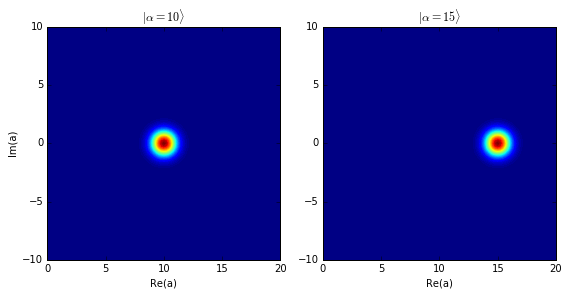

In [5]:
Q1 = myqfunc(psi1, areal, aimag, 2)
Q2 = myqfunc(psi2, areal, aimag, 2)
plt.figure(figsize=(8, 4))
ax1 = plt.subplot(121)
ax1.contourf(areal, aimag, Q1, 100)
ax1.set_aspect('equal')
plt.xlabel('Re(a)')
plt.ylabel('Im(a)')
plt.title(r'$|\alpha=10\rangle$')

ax2 = plt.subplot(122)
ax2.contourf(areal, aimag, Q2, 100)
ax2.set_aspect('equal')
plt.xlabel('Re(a)')
plt.title(r'$|\alpha=15\rangle$')
plt.tight_layout()

The downside of this approach is that it takes much longer time to calculate the Q function for large photon number (e.g., a few minutes for N = 500).

## Software version

In [6]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,3.2.0.dev-88e1862
Numpy,1.11.1
SciPy,0.18.0
matplotlib,1.5.1
Cython,0.24.1
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,5.1.0
Python,"3.5.2 |Continuum Analytics, Inc.| (default, Jul 2 2016, 17:53:06) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]
